<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[10:07:08] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


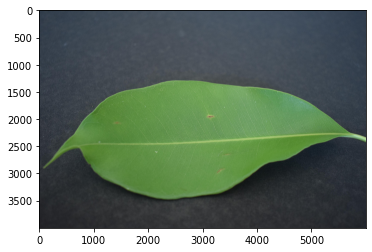

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

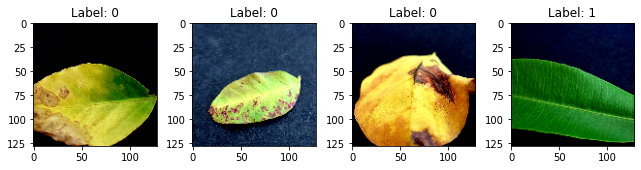

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[10:07:15] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[10:07:17] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2516459301365708 samples/sec                   batch loss = 1.7765685319900513 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2472790048481706 samples/sec                   batch loss = 0.5648614764213562 | accuracy = 0.45


Epoch[1] Batch[15] Speed: 1.2605255761230965 samples/sec                   batch loss = 0.470398485660553 | accuracy = 0.4666666666666667


Epoch[1] Batch[20] Speed: 1.2596608292196105 samples/sec                   batch loss = 0.7669018507003784 | accuracy = 0.4875


Epoch[1] Batch[25] Speed: 1.258847988465298 samples/sec                   batch loss = 0.771271288394928 | accuracy = 0.49


Epoch[1] Batch[30] Speed: 1.2631444536196976 samples/sec                   batch loss = 1.3238906860351562 | accuracy = 0.48333333333333334


Epoch[1] Batch[35] Speed: 1.2654197523619684 samples/sec                   batch loss = 0.5926817655563354 | accuracy = 0.5071428571428571


Epoch[1] Batch[40] Speed: 1.2676393748790613 samples/sec                   batch loss = 0.7360042333602905 | accuracy = 0.5


Epoch[1] Batch[45] Speed: 1.2694115626416314 samples/sec                   batch loss = 0.4951503574848175 | accuracy = 0.5166666666666667


Epoch[1] Batch[50] Speed: 1.2776756153070834 samples/sec                   batch loss = 1.1785497665405273 | accuracy = 0.535


Epoch[1] Batch[55] Speed: 1.2694120428781392 samples/sec                   batch loss = 0.618302583694458 | accuracy = 0.5409090909090909


Epoch[1] Batch[60] Speed: 1.2672764753474202 samples/sec                   batch loss = 0.6591759920120239 | accuracy = 0.5333333333333333


Epoch[1] Batch[65] Speed: 1.2659989815996733 samples/sec                   batch loss = 0.5557045340538025 | accuracy = 0.55


Epoch[1] Batch[70] Speed: 1.2604309706373025 samples/sec                   batch loss = 0.5753938555717468 | accuracy = 0.5571428571428572


Epoch[1] Batch[75] Speed: 1.259980960466081 samples/sec                   batch loss = 0.48590534925460815 | accuracy = 0.58


Epoch[1] Batch[80] Speed: 1.2617737270309486 samples/sec                   batch loss = 0.6634087562561035 | accuracy = 0.578125


Epoch[1] Batch[85] Speed: 1.2576180599334206 samples/sec                   batch loss = 0.48916658759117126 | accuracy = 0.5852941176470589


Epoch[1] Batch[90] Speed: 1.2531726476499898 samples/sec                   batch loss = 0.530698835849762 | accuracy = 0.5888888888888889


Epoch[1] Batch[95] Speed: 1.2565920048762063 samples/sec                   batch loss = 0.6285544633865356 | accuracy = 0.5894736842105263


Epoch[1] Batch[100] Speed: 1.251817862062595 samples/sec                   batch loss = 2.574925184249878 | accuracy = 0.59


Epoch[1] Batch[105] Speed: 1.2610241230049795 samples/sec                   batch loss = 0.33437153697013855 | accuracy = 0.5952380952380952


Epoch[1] Batch[110] Speed: 1.252469035067039 samples/sec                   batch loss = 0.21711590886116028 | accuracy = 0.6


Epoch[1] Batch[115] Speed: 1.267458665152112 samples/sec                   batch loss = 0.8841752409934998 | accuracy = 0.5978260869565217


Epoch[1] Batch[120] Speed: 1.272077273851502 samples/sec                   batch loss = 1.4301565885543823 | accuracy = 0.6020833333333333


Epoch[1] Batch[125] Speed: 1.264825891346997 samples/sec                   batch loss = 0.6119142770767212 | accuracy = 0.604


Epoch[1] Batch[130] Speed: 1.26528757601941 samples/sec                   batch loss = 0.8864079117774963 | accuracy = 0.6


Epoch[1] Batch[135] Speed: 1.2707846973648202 samples/sec                   batch loss = 0.8694254755973816 | accuracy = 0.5925925925925926


Epoch[1] Batch[140] Speed: 1.2646625700278 samples/sec                   batch loss = 0.7548372149467468 | accuracy = 0.5910714285714286


Epoch[1] Batch[145] Speed: 1.2712712609557364 samples/sec                   batch loss = 0.2704535126686096 | accuracy = 0.5948275862068966


Epoch[1] Batch[150] Speed: 1.265786746084954 samples/sec                   batch loss = 0.7085973024368286 | accuracy = 0.5966666666666667


Epoch[1] Batch[155] Speed: 1.2758129600304664 samples/sec                   batch loss = 0.6774592995643616 | accuracy = 0.6


Epoch[1] Batch[160] Speed: 1.2708188688683608 samples/sec                   batch loss = 0.30475687980651855 | accuracy = 0.60625


Epoch[1] Batch[165] Speed: 1.26844558255545 samples/sec                   batch loss = 0.40227222442626953 | accuracy = 0.6045454545454545


Epoch[1] Batch[170] Speed: 1.2725590364750303 samples/sec                   batch loss = 0.3877526819705963 | accuracy = 0.6102941176470589


Epoch[1] Batch[175] Speed: 1.2716278741910312 samples/sec                   batch loss = 0.3205327093601227 | accuracy = 0.6185714285714285


Epoch[1] Batch[180] Speed: 1.2710493579302247 samples/sec                   batch loss = 0.1887064129114151 | accuracy = 0.625


Epoch[1] Batch[185] Speed: 1.2680915184915098 samples/sec                   batch loss = 0.7491543889045715 | accuracy = 0.6256756756756757


Epoch[1] Batch[190] Speed: 1.2698323891266752 samples/sec                   batch loss = 0.9235323667526245 | accuracy = 0.6276315789473684


Epoch[1] Batch[195] Speed: 1.2714212627368784 samples/sec                   batch loss = 0.31175243854522705 | accuracy = 0.6358974358974359


Epoch[1] Batch[200] Speed: 1.266845192106139 samples/sec                   batch loss = 0.505151093006134 | accuracy = 0.6375


Epoch[1] Batch[205] Speed: 1.2750556960443762 samples/sec                   batch loss = 0.43928489089012146 | accuracy = 0.6402439024390244


Epoch[1] Batch[210] Speed: 1.2703748788097504 samples/sec                   batch loss = 0.9119712710380554 | accuracy = 0.6404761904761904


Epoch[1] Batch[215] Speed: 1.2720643495381898 samples/sec                   batch loss = 0.6812419295310974 | accuracy = 0.6383720930232558


Epoch[1] Batch[220] Speed: 1.2678825093034414 samples/sec                   batch loss = 0.8090583086013794 | accuracy = 0.6397727272727273


Epoch[1] Batch[225] Speed: 1.270470982981421 samples/sec                   batch loss = 0.4730305075645447 | accuracy = 0.64


Epoch[1] Batch[230] Speed: 1.26720956749411 samples/sec                   batch loss = 0.5472143888473511 | accuracy = 0.6369565217391304


Epoch[1] Batch[235] Speed: 1.2714530595683664 samples/sec                   batch loss = 0.7532563209533691 | accuracy = 0.6361702127659574


Epoch[1] Batch[240] Speed: 1.263924098933615 samples/sec                   batch loss = 0.7628974914550781 | accuracy = 0.6364583333333333


Epoch[1] Batch[245] Speed: 1.270790280189099 samples/sec                   batch loss = 0.6196950078010559 | accuracy = 0.6316326530612245


Epoch[1] Batch[250] Speed: 1.2720438062075272 samples/sec                   batch loss = 0.5597735047340393 | accuracy = 0.629


Epoch[1] Batch[255] Speed: 1.2689800729504765 samples/sec                   batch loss = 0.25077104568481445 | accuracy = 0.6313725490196078


Epoch[1] Batch[260] Speed: 1.2678558730095875 samples/sec                   batch loss = 0.9042503833770752 | accuracy = 0.6326923076923077


Epoch[1] Batch[265] Speed: 1.2697559855126923 samples/sec                   batch loss = 0.3619788885116577 | accuracy = 0.6339622641509434


Epoch[1] Batch[270] Speed: 1.2685106068637813 samples/sec                   batch loss = 0.3389245867729187 | accuracy = 0.6398148148148148


Epoch[1] Batch[275] Speed: 1.2716272958936374 samples/sec                   batch loss = 0.30028194189071655 | accuracy = 0.6409090909090909


Epoch[1] Batch[280] Speed: 1.2710245142373064 samples/sec                   batch loss = 0.4598691165447235 | accuracy = 0.64375


Epoch[1] Batch[285] Speed: 1.26892622934391 samples/sec                   batch loss = 0.39714035391807556 | accuracy = 0.6456140350877193


Epoch[1] Batch[290] Speed: 1.2686642748603614 samples/sec                   batch loss = 0.8160213232040405 | accuracy = 0.6482758620689655


Epoch[1] Batch[295] Speed: 1.272379816373771 samples/sec                   batch loss = 0.4608911871910095 | accuracy = 0.6491525423728813


Epoch[1] Batch[300] Speed: 1.26550470335962 samples/sec                   batch loss = 0.3225906789302826 | accuracy = 0.6516666666666666


Epoch[1] Batch[305] Speed: 1.2684116344593148 samples/sec                   batch loss = 0.37044939398765564 | accuracy = 0.6549180327868852


Epoch[1] Batch[310] Speed: 1.2662752235690056 samples/sec                   batch loss = 0.6748730540275574 | accuracy = 0.6556451612903226


Epoch[1] Batch[315] Speed: 1.2634708302554027 samples/sec                   batch loss = 0.4834464192390442 | accuracy = 0.6563492063492063


Epoch[1] Batch[320] Speed: 1.2655431736867566 samples/sec                   batch loss = 0.3364439606666565 | accuracy = 0.65625


Epoch[1] Batch[325] Speed: 1.2648539262175278 samples/sec                   batch loss = 0.5487146377563477 | accuracy = 0.6576923076923077


Epoch[1] Batch[330] Speed: 1.2648911172493056 samples/sec                   batch loss = 1.005847454071045 | accuracy = 0.6583333333333333


Epoch[1] Batch[335] Speed: 1.2630836868559454 samples/sec                   batch loss = 0.7604600191116333 | accuracy = 0.6604477611940298


Epoch[1] Batch[340] Speed: 1.2657666915033496 samples/sec                   batch loss = 0.5116298794746399 | accuracy = 0.6602941176470588


Epoch[1] Batch[345] Speed: 1.2636662041995628 samples/sec                   batch loss = 0.43901902437210083 | accuracy = 0.6579710144927536


Epoch[1] Batch[350] Speed: 1.2707219420943927 samples/sec                   batch loss = 0.9282112717628479 | accuracy = 0.655


Epoch[1] Batch[355] Speed: 1.268026249626917 samples/sec                   batch loss = 0.36643844842910767 | accuracy = 0.6563380281690141


Epoch[1] Batch[360] Speed: 1.2648168327259246 samples/sec                   batch loss = 0.442974328994751 | accuracy = 0.65625


Epoch[1] Batch[365] Speed: 1.2631063191769927 samples/sec                   batch loss = 0.5029963850975037 | accuracy = 0.6554794520547945


Epoch[1] Batch[370] Speed: 1.263827364173076 samples/sec                   batch loss = 0.6320412158966064 | accuracy = 0.6567567567567567


Epoch[1] Batch[375] Speed: 1.2599024262177685 samples/sec                   batch loss = 0.6998293995857239 | accuracy = 0.658


Epoch[1] Batch[380] Speed: 1.2638274593771748 samples/sec                   batch loss = 0.48782113194465637 | accuracy = 0.6578947368421053


Epoch[1] Batch[385] Speed: 1.2667262987552537 samples/sec                   batch loss = 0.40932130813598633 | accuracy = 0.6610389610389611


Epoch[1] Batch[390] Speed: 1.2632029435856176 samples/sec                   batch loss = 0.8813185095787048 | accuracy = 0.6608974358974359


Epoch[1] Batch[395] Speed: 1.2621231320411903 samples/sec                   batch loss = 0.1826360523700714 | accuracy = 0.6620253164556962


Epoch[1] Batch[400] Speed: 1.2633977589869936 samples/sec                   batch loss = 0.274630069732666 | accuracy = 0.661875


Epoch[1] Batch[405] Speed: 1.263560753767512 samples/sec                   batch loss = 0.5280266404151917 | accuracy = 0.6635802469135802


Epoch[1] Batch[410] Speed: 1.262459810733547 samples/sec                   batch loss = 0.9407570362091064 | accuracy = 0.6652439024390244


Epoch[1] Batch[415] Speed: 1.2584745282769068 samples/sec                   batch loss = 0.6447601318359375 | accuracy = 0.6656626506024096


Epoch[1] Batch[420] Speed: 1.2679783325645853 samples/sec                   batch loss = 0.7083204984664917 | accuracy = 0.6654761904761904


Epoch[1] Batch[425] Speed: 1.2617486752636744 samples/sec                   batch loss = 0.443979948759079 | accuracy = 0.6635294117647059


Epoch[1] Batch[430] Speed: 1.257983088492051 samples/sec                   batch loss = 1.007921576499939 | accuracy = 0.6633720930232558


Epoch[1] Batch[435] Speed: 1.259241707121578 samples/sec                   batch loss = 0.7579293251037598 | accuracy = 0.6632183908045977


Epoch[1] Batch[440] Speed: 1.261468144448386 samples/sec                   batch loss = 0.5667643547058105 | accuracy = 0.6642045454545454


Epoch[1] Batch[445] Speed: 1.2643054695108262 samples/sec                   batch loss = 0.6078917980194092 | accuracy = 0.6657303370786517


Epoch[1] Batch[450] Speed: 1.2696211723802038 samples/sec                   batch loss = 0.26354894042015076 | accuracy = 0.6683333333333333


Epoch[1] Batch[455] Speed: 1.2634974729246227 samples/sec                   batch loss = 0.5357785820960999 | accuracy = 0.6708791208791208


Epoch[1] Batch[460] Speed: 1.2711464309710534 samples/sec                   batch loss = 1.2431635856628418 | accuracy = 0.6695652173913044


Epoch[1] Batch[465] Speed: 1.2625767643111012 samples/sec                   batch loss = 0.6508533954620361 | accuracy = 0.6688172043010753


Epoch[1] Batch[470] Speed: 1.2704813734925582 samples/sec                   batch loss = 0.27071255445480347 | accuracy = 0.6696808510638298


Epoch[1] Batch[475] Speed: 1.2674900725762255 samples/sec                   batch loss = 0.8790865540504456 | accuracy = 0.6673684210526316


Epoch[1] Batch[480] Speed: 1.2621985248634937 samples/sec                   batch loss = 0.4746280312538147 | accuracy = 0.6666666666666666


Epoch[1] Batch[485] Speed: 1.2648750962290138 samples/sec                   batch loss = 0.46973150968551636 | accuracy = 0.6670103092783505


Epoch[1] Batch[490] Speed: 1.2676989523880406 samples/sec                   batch loss = 0.8397614359855652 | accuracy = 0.6678571428571428


Epoch[1] Batch[495] Speed: 1.2715164652706616 samples/sec                   batch loss = 0.9484685659408569 | accuracy = 0.6696969696969697


Epoch[1] Batch[500] Speed: 1.262416778030604 samples/sec                   batch loss = 0.3803349733352661 | accuracy = 0.671


Epoch[1] Batch[505] Speed: 1.2647693486035474 samples/sec                   batch loss = 0.38894107937812805 | accuracy = 0.6732673267326733


Epoch[1] Batch[510] Speed: 1.2658349751804623 samples/sec                   batch loss = 0.9062453508377075 | accuracy = 0.6740196078431373


Epoch[1] Batch[515] Speed: 1.2647887994996696 samples/sec                   batch loss = 0.3483695089817047 | accuracy = 0.6757281553398058


Epoch[1] Batch[520] Speed: 1.2672241162402005 samples/sec                   batch loss = 0.827474057674408 | accuracy = 0.675


Epoch[1] Batch[525] Speed: 1.2694246252041215 samples/sec                   batch loss = 0.19135144352912903 | accuracy = 0.6752380952380952


Epoch[1] Batch[530] Speed: 1.2671619992548335 samples/sec                   batch loss = 2.093475818634033 | accuracy = 0.6740566037735849


Epoch[1] Batch[535] Speed: 1.2637936628234083 samples/sec                   batch loss = 0.36787882447242737 | accuracy = 0.6752336448598131


Epoch[1] Batch[540] Speed: 1.2680003739634662 samples/sec                   batch loss = 0.41877299547195435 | accuracy = 0.6754629629629629


Epoch[1] Batch[545] Speed: 1.2568678286057997 samples/sec                   batch loss = 0.2043011486530304 | accuracy = 0.6775229357798165


Epoch[1] Batch[550] Speed: 1.255552682655044 samples/sec                   batch loss = 0.4875931441783905 | accuracy = 0.6795454545454546


Epoch[1] Batch[555] Speed: 1.25065159473357 samples/sec                   batch loss = 0.6908624172210693 | accuracy = 0.6797297297297298


Epoch[1] Batch[560] Speed: 1.259327532109361 samples/sec                   batch loss = 0.35029128193855286 | accuracy = 0.6803571428571429


Epoch[1] Batch[565] Speed: 1.2603612803849682 samples/sec                   batch loss = 0.3750613033771515 | accuracy = 0.6814159292035398


Epoch[1] Batch[570] Speed: 1.2598775433117224 samples/sec                   batch loss = 0.28399693965911865 | accuracy = 0.6824561403508772


Epoch[1] Batch[575] Speed: 1.2648080602902425 samples/sec                   batch loss = 0.821067214012146 | accuracy = 0.6817391304347826


Epoch[1] Batch[580] Speed: 1.26355628107872 samples/sec                   batch loss = 0.4802301526069641 | accuracy = 0.6814655172413793


Epoch[1] Batch[585] Speed: 1.2584081690393123 samples/sec                   batch loss = 0.4124443233013153 | accuracy = 0.6807692307692308


Epoch[1] Batch[590] Speed: 1.261975411014917 samples/sec                   batch loss = 0.8977484107017517 | accuracy = 0.6813559322033899


Epoch[1] Batch[595] Speed: 1.2636046258616325 samples/sec                   batch loss = 0.3249238431453705 | accuracy = 0.6819327731092437


Epoch[1] Batch[600] Speed: 1.2670082165297245 samples/sec                   batch loss = 1.1269309520721436 | accuracy = 0.6825


Epoch[1] Batch[605] Speed: 1.2609058458846727 samples/sec                   batch loss = 0.6796897649765015 | accuracy = 0.6822314049586777


Epoch[1] Batch[610] Speed: 1.2598115090338142 samples/sec                   batch loss = 0.5571607947349548 | accuracy = 0.6823770491803278


Epoch[1] Batch[615] Speed: 1.2642138205116786 samples/sec                   batch loss = 0.8309382796287537 | accuracy = 0.6817073170731708


Epoch[1] Batch[620] Speed: 1.2585852684479728 samples/sec                   batch loss = 0.8372734189033508 | accuracy = 0.6814516129032258


Epoch[1] Batch[625] Speed: 1.258990632245744 samples/sec                   batch loss = 1.1036913394927979 | accuracy = 0.6812


Epoch[1] Batch[630] Speed: 1.2577817355080325 samples/sec                   batch loss = 0.5316697359085083 | accuracy = 0.6813492063492064


Epoch[1] Batch[635] Speed: 1.2586716649775311 samples/sec                   batch loss = 0.558212161064148 | accuracy = 0.6826771653543308


Epoch[1] Batch[640] Speed: 1.256717004861785 samples/sec                   batch loss = 0.4992336630821228 | accuracy = 0.68359375


Epoch[1] Batch[645] Speed: 1.2533329209646946 samples/sec                   batch loss = 0.5886912941932678 | accuracy = 0.6841085271317829


Epoch[1] Batch[650] Speed: 1.256744493133688 samples/sec                   batch loss = 0.760805606842041 | accuracy = 0.6842307692307692


Epoch[1] Batch[655] Speed: 1.2521029939780122 samples/sec                   batch loss = 0.5199611783027649 | accuracy = 0.6851145038167938


Epoch[1] Batch[660] Speed: 1.2613216197906685 samples/sec                   batch loss = 0.523838222026825 | accuracy = 0.6856060606060606


Epoch[1] Batch[665] Speed: 1.2576885785176033 samples/sec                   batch loss = 0.7216087579727173 | accuracy = 0.6864661654135338


Epoch[1] Batch[670] Speed: 1.2532965937470142 samples/sec                   batch loss = 0.1831061691045761 | accuracy = 0.6865671641791045


Epoch[1] Batch[675] Speed: 1.256982335718375 samples/sec                   batch loss = 0.889042317867279 | accuracy = 0.6862962962962963


Epoch[1] Batch[680] Speed: 1.2529273553453986 samples/sec                   batch loss = 0.9101569056510925 | accuracy = 0.6852941176470588


Epoch[1] Batch[685] Speed: 1.2580182729356866 samples/sec                   batch loss = 0.5133472084999084 | accuracy = 0.6861313868613139


Epoch[1] Batch[690] Speed: 1.2638545931298633 samples/sec                   batch loss = 0.6203127503395081 | accuracy = 0.6869565217391305


Epoch[1] Batch[695] Speed: 1.2568333675561374 samples/sec                   batch loss = 0.7807976603507996 | accuracy = 0.6874100719424461


Epoch[1] Batch[700] Speed: 1.258166201187912 samples/sec                   batch loss = 0.4455268979072571 | accuracy = 0.6882142857142857


Epoch[1] Batch[705] Speed: 1.2565121045112226 samples/sec                   batch loss = 0.39360883831977844 | accuracy = 0.6886524822695036


Epoch[1] Batch[710] Speed: 1.2584227051726906 samples/sec                   batch loss = 0.8465886116027832 | accuracy = 0.6880281690140845


Epoch[1] Batch[715] Speed: 1.2600275179196934 samples/sec                   batch loss = 0.783891499042511 | accuracy = 0.6888111888111889


Epoch[1] Batch[720] Speed: 1.2578995215364817 samples/sec                   batch loss = 0.8137907981872559 | accuracy = 0.6885416666666667


Epoch[1] Batch[725] Speed: 1.255532575214054 samples/sec                   batch loss = 0.10887766629457474 | accuracy = 0.6893103448275862


Epoch[1] Batch[730] Speed: 1.2547029065252013 samples/sec                   batch loss = 0.4842734634876251 | accuracy = 0.6904109589041096


Epoch[1] Batch[735] Speed: 1.2613961581782598 samples/sec                   batch loss = 0.48497286438941956 | accuracy = 0.6904761904761905


Epoch[1] Batch[740] Speed: 1.25440730410503 samples/sec                   batch loss = 0.3096325695514679 | accuracy = 0.6912162162162162


Epoch[1] Batch[745] Speed: 1.2591021247234282 samples/sec                   batch loss = 0.3586941361427307 | accuracy = 0.6926174496644295


Epoch[1] Batch[750] Speed: 1.2541686535730563 samples/sec                   batch loss = 0.33140015602111816 | accuracy = 0.6906666666666667


Epoch[1] Batch[755] Speed: 1.2595047012920775 samples/sec                   batch loss = 0.6175445914268494 | accuracy = 0.6900662251655629


Epoch[1] Batch[760] Speed: 1.260974459075829 samples/sec                   batch loss = 0.6668146848678589 | accuracy = 0.6891447368421053


Epoch[1] Batch[765] Speed: 1.2573594337915888 samples/sec                   batch loss = 0.5839250683784485 | accuracy = 0.6901960784313725


Epoch[1] Batch[770] Speed: 1.2639103875944464 samples/sec                   batch loss = 0.552298367023468 | accuracy = 0.6905844155844156


Epoch[1] Batch[775] Speed: 1.2618941602062208 samples/sec                   batch loss = 0.8018567562103271 | accuracy = 0.6903225806451613


Epoch[1] Batch[780] Speed: 1.2560836016679784 samples/sec                   batch loss = 0.47891369462013245 | accuracy = 0.6907051282051282


Epoch[1] Batch[785] Speed: 1.2581705414450755 samples/sec                   batch loss = 0.3241277039051056 | accuracy = 0.6914012738853503


[Epoch 1] training: accuracy=0.6916243654822335
[Epoch 1] time cost: 651.5804884433746
[Epoch 1] validation: validation accuracy=0.7455555555555555


Epoch[2] Batch[5] Speed: 1.2595899001665667 samples/sec                   batch loss = 0.4924277663230896 | accuracy = 0.8


Epoch[2] Batch[10] Speed: 1.2610129388017863 samples/sec                   batch loss = 0.5963481068611145 | accuracy = 0.8


Epoch[2] Batch[15] Speed: 1.2677880417472231 samples/sec                   batch loss = 0.6558247208595276 | accuracy = 0.8333333333333334


Epoch[2] Batch[20] Speed: 1.2704631902096006 samples/sec                   batch loss = 0.49896636605262756 | accuracy = 0.8375


Epoch[2] Batch[25] Speed: 1.2716270067451376 samples/sec                   batch loss = 0.5696800351142883 | accuracy = 0.82


Epoch[2] Batch[30] Speed: 1.26535676235749 samples/sec                   batch loss = 0.2842264771461487 | accuracy = 0.8166666666666667


Epoch[2] Batch[35] Speed: 1.265948925047613 samples/sec                   batch loss = 0.8244810700416565 | accuracy = 0.8


Epoch[2] Batch[40] Speed: 1.2640786577265353 samples/sec                   batch loss = 0.4248832166194916 | accuracy = 0.7875


Epoch[2] Batch[45] Speed: 1.2651218458702225 samples/sec                   batch loss = 0.710004448890686 | accuracy = 0.7833333333333333


Epoch[2] Batch[50] Speed: 1.2687636704935288 samples/sec                   batch loss = 0.6135600805282593 | accuracy = 0.77


Epoch[2] Batch[55] Speed: 1.2615594906333967 samples/sec                   batch loss = 0.48086869716644287 | accuracy = 0.7772727272727272


Epoch[2] Batch[60] Speed: 1.264529979948824 samples/sec                   batch loss = 0.31353577971458435 | accuracy = 0.7875


Epoch[2] Batch[65] Speed: 1.2660243935016062 samples/sec                   batch loss = 0.5896057486534119 | accuracy = 0.7807692307692308


Epoch[2] Batch[70] Speed: 1.2662814358602783 samples/sec                   batch loss = 0.6096084117889404 | accuracy = 0.7785714285714286


Epoch[2] Batch[75] Speed: 1.2648006228857438 samples/sec                   batch loss = 0.27612417936325073 | accuracy = 0.7866666666666666


Epoch[2] Batch[80] Speed: 1.2669464077317398 samples/sec                   batch loss = 0.38724803924560547 | accuracy = 0.784375


Epoch[2] Batch[85] Speed: 1.2686047984356823 samples/sec                   batch loss = 0.415432333946228 | accuracy = 0.788235294117647


Epoch[2] Batch[90] Speed: 1.269706304070803 samples/sec                   batch loss = 0.3394160866737366 | accuracy = 0.7861111111111111


Epoch[2] Batch[95] Speed: 1.2640497048353478 samples/sec                   batch loss = 0.5267781019210815 | accuracy = 0.7763157894736842


Epoch[2] Batch[100] Speed: 1.2664838943399006 samples/sec                   batch loss = 0.9558948874473572 | accuracy = 0.78


Epoch[2] Batch[105] Speed: 1.261855721588737 samples/sec                   batch loss = 0.7188029885292053 | accuracy = 0.7761904761904762


Epoch[2] Batch[110] Speed: 1.2580060100375245 samples/sec                   batch loss = 0.2877364754676819 | accuracy = 0.7727272727272727


Epoch[2] Batch[115] Speed: 1.2511593415214595 samples/sec                   batch loss = 0.48456674814224243 | accuracy = 0.7760869565217391


Epoch[2] Batch[120] Speed: 1.2545312131378243 samples/sec                   batch loss = 0.5808815956115723 | accuracy = 0.7708333333333334


Epoch[2] Batch[125] Speed: 1.260992561314476 samples/sec                   batch loss = 0.6170169711112976 | accuracy = 0.776


Epoch[2] Batch[130] Speed: 1.2615699256189392 samples/sec                   batch loss = 0.8588798642158508 | accuracy = 0.7730769230769231


Epoch[2] Batch[135] Speed: 1.2589640848292392 samples/sec                   batch loss = 0.5648107528686523 | accuracy = 0.7703703703703704


Epoch[2] Batch[140] Speed: 1.2596440892429492 samples/sec                   batch loss = 0.5777541399002075 | accuracy = 0.7660714285714286


Epoch[2] Batch[145] Speed: 1.2635755043485732 samples/sec                   batch loss = 0.7074896097183228 | accuracy = 0.7637931034482759


Epoch[2] Batch[150] Speed: 1.2621486734369083 samples/sec                   batch loss = 0.43195316195487976 | accuracy = 0.7616666666666667


Epoch[2] Batch[155] Speed: 1.2597134164471688 samples/sec                   batch loss = 0.33883902430534363 | accuracy = 0.7548387096774194


Epoch[2] Batch[160] Speed: 1.2649594972376632 samples/sec                   batch loss = 0.31287407875061035 | accuracy = 0.7546875


Epoch[2] Batch[165] Speed: 1.2668891012467487 samples/sec                   batch loss = 0.21833814680576324 | accuracy = 0.7575757575757576


Epoch[2] Batch[170] Speed: 1.2612192149990615 samples/sec                   batch loss = 0.49226316809654236 | accuracy = 0.7573529411764706


Epoch[2] Batch[175] Speed: 1.256299368758318 samples/sec                   batch loss = 0.24603870511054993 | accuracy = 0.7585714285714286


Epoch[2] Batch[180] Speed: 1.2582498979471 samples/sec                   batch loss = 0.29586827754974365 | accuracy = 0.7541666666666667


Epoch[2] Batch[185] Speed: 1.2599019531495528 samples/sec                   batch loss = 1.1060194969177246 | accuracy = 0.7567567567567568


Epoch[2] Batch[190] Speed: 1.2652122907943322 samples/sec                   batch loss = 0.6928700804710388 | accuracy = 0.756578947368421


Epoch[2] Batch[195] Speed: 1.2580157260063978 samples/sec                   batch loss = 0.11789647489786148 | accuracy = 0.7564102564102564


Epoch[2] Batch[200] Speed: 1.2556641308969407 samples/sec                   batch loss = 0.8276047706604004 | accuracy = 0.7525


Epoch[2] Batch[205] Speed: 1.2601167626569802 samples/sec                   batch loss = 0.6141575574874878 | accuracy = 0.7524390243902439


Epoch[2] Batch[210] Speed: 1.2573098696467406 samples/sec                   batch loss = 0.5704283714294434 | accuracy = 0.7547619047619047


Epoch[2] Batch[215] Speed: 1.2588320257090453 samples/sec                   batch loss = 0.6999333500862122 | accuracy = 0.7546511627906977


Epoch[2] Batch[220] Speed: 1.2682747097395244 samples/sec                   batch loss = 0.40566179156303406 | accuracy = 0.7579545454545454


Epoch[2] Batch[225] Speed: 1.2639222897815492 samples/sec                   batch loss = 0.5272636413574219 | accuracy = 0.7588888888888888


Epoch[2] Batch[230] Speed: 1.2634163114381645 samples/sec                   batch loss = 0.49255573749542236 | accuracy = 0.7608695652173914


Epoch[2] Batch[235] Speed: 1.2641418062972696 samples/sec                   batch loss = 0.16537609696388245 | accuracy = 0.7606382978723404


Epoch[2] Batch[240] Speed: 1.26168747342534 samples/sec                   batch loss = 0.5026456117630005 | accuracy = 0.7583333333333333


Epoch[2] Batch[245] Speed: 1.2609266944071478 samples/sec                   batch loss = 0.513579785823822 | accuracy = 0.7581632653061224


Epoch[2] Batch[250] Speed: 1.2639748525205867 samples/sec                   batch loss = 0.8466765284538269 | accuracy = 0.755


Epoch[2] Batch[255] Speed: 1.259362980864865 samples/sec                   batch loss = 0.3812035024166107 | accuracy = 0.7568627450980392


Epoch[2] Batch[260] Speed: 1.2612765785977118 samples/sec                   batch loss = 0.3206573724746704 | accuracy = 0.7548076923076923


Epoch[2] Batch[265] Speed: 1.2609201554781642 samples/sec                   batch loss = 0.3507368266582489 | accuracy = 0.7547169811320755


Epoch[2] Batch[270] Speed: 1.2631508254343817 samples/sec                   batch loss = 0.39812010526657104 | accuracy = 0.7555555555555555


Epoch[2] Batch[275] Speed: 1.2620056929060728 samples/sec                   batch loss = 0.30112043023109436 | accuracy = 0.7581818181818182


Epoch[2] Batch[280] Speed: 1.2630799782756352 samples/sec                   batch loss = 1.9001317024230957 | accuracy = 0.7571428571428571


Epoch[2] Batch[285] Speed: 1.258607362169377 samples/sec                   batch loss = 0.6396729946136475 | accuracy = 0.7570175438596491


Epoch[2] Batch[290] Speed: 1.2612450990843105 samples/sec                   batch loss = 0.2141871154308319 | accuracy = 0.756896551724138


Epoch[2] Batch[295] Speed: 1.2572849948186466 samples/sec                   batch loss = 0.6522561311721802 | accuracy = 0.7559322033898305


Epoch[2] Batch[300] Speed: 1.2663076237273874 samples/sec                   batch loss = 0.7512956857681274 | accuracy = 0.7508333333333334


Epoch[2] Batch[305] Speed: 1.2608774171923387 samples/sec                   batch loss = 0.3272382915019989 | accuracy = 0.7540983606557377


Epoch[2] Batch[310] Speed: 1.2592896277813865 samples/sec                   batch loss = 0.4374164044857025 | accuracy = 0.7532258064516129


Epoch[2] Batch[315] Speed: 1.2588737753113697 samples/sec                   batch loss = 0.332676500082016 | accuracy = 0.7523809523809524


Epoch[2] Batch[320] Speed: 1.2588869997448042 samples/sec                   batch loss = 0.5446643233299255 | accuracy = 0.75234375


Epoch[2] Batch[325] Speed: 1.2541513092357781 samples/sec                   batch loss = 0.7218503952026367 | accuracy = 0.7515384615384615


Epoch[2] Batch[330] Speed: 1.2586229415418169 samples/sec                   batch loss = 0.2688838243484497 | accuracy = 0.7515151515151515


Epoch[2] Batch[335] Speed: 1.256625040858326 samples/sec                   batch loss = 0.4605213701725006 | accuracy = 0.7514925373134328


Epoch[2] Batch[340] Speed: 1.2613959685019716 samples/sec                   batch loss = 0.6967539191246033 | accuracy = 0.7507352941176471


Epoch[2] Batch[345] Speed: 1.2612199734919436 samples/sec                   batch loss = 1.8553411960601807 | accuracy = 0.7514492753623189


Epoch[2] Batch[350] Speed: 1.262926233998241 samples/sec                   batch loss = 0.18461373448371887 | accuracy = 0.7521428571428571


Epoch[2] Batch[355] Speed: 1.264426195902519 samples/sec                   batch loss = 0.3833843767642975 | accuracy = 0.7535211267605634


Epoch[2] Batch[360] Speed: 1.2625494953742609 samples/sec                   batch loss = 0.16172732412815094 | accuracy = 0.7541666666666667


Epoch[2] Batch[365] Speed: 1.260172984813898 samples/sec                   batch loss = 0.5528455376625061 | accuracy = 0.7554794520547945


Epoch[2] Batch[370] Speed: 1.253577529114462 samples/sec                   batch loss = 0.3450925946235657 | accuracy = 0.7547297297297297


Epoch[2] Batch[375] Speed: 1.2634202122792741 samples/sec                   batch loss = 0.2875692844390869 | accuracy = 0.7546666666666667


Epoch[2] Batch[380] Speed: 1.2597510625188 samples/sec                   batch loss = 0.4902004301548004 | accuracy = 0.7546052631578948


Epoch[2] Batch[385] Speed: 1.2676694502849444 samples/sec                   batch loss = 0.6072722673416138 | accuracy = 0.7525974025974026


Epoch[2] Batch[390] Speed: 1.2571964333458425 samples/sec                   batch loss = 0.948499858379364 | accuracy = 0.7525641025641026


Epoch[2] Batch[395] Speed: 1.2660500930414476 samples/sec                   batch loss = 0.5169891715049744 | accuracy = 0.7531645569620253


Epoch[2] Batch[400] Speed: 1.2627800357626262 samples/sec                   batch loss = 0.7223405241966248 | accuracy = 0.753125


Epoch[2] Batch[405] Speed: 1.2563895915337342 samples/sec                   batch loss = 0.39752107858657837 | accuracy = 0.7537037037037037


Epoch[2] Batch[410] Speed: 1.2624053791305865 samples/sec                   batch loss = 0.5236075520515442 | accuracy = 0.7536585365853659


Epoch[2] Batch[415] Speed: 1.2578012549661592 samples/sec                   batch loss = 0.5470898747444153 | accuracy = 0.7536144578313253


Epoch[2] Batch[420] Speed: 1.2634529422365368 samples/sec                   batch loss = 0.13963881134986877 | accuracy = 0.7547619047619047


Epoch[2] Batch[425] Speed: 1.2554254716614752 samples/sec                   batch loss = 0.6046084761619568 | accuracy = 0.7547058823529412


Epoch[2] Batch[430] Speed: 1.2561337275163045 samples/sec                   batch loss = 0.6191730499267578 | accuracy = 0.7534883720930232


Epoch[2] Batch[435] Speed: 1.2609414783226756 samples/sec                   batch loss = 0.695949912071228 | accuracy = 0.753448275862069


Epoch[2] Batch[440] Speed: 1.2600684004720257 samples/sec                   batch loss = 0.549805760383606 | accuracy = 0.7528409090909091


Epoch[2] Batch[445] Speed: 1.2622596813251021 samples/sec                   batch loss = 0.3173297345638275 | accuracy = 0.7539325842696629


Epoch[2] Batch[450] Speed: 1.25988634209773 samples/sec                   batch loss = 0.12264253944158554 | accuracy = 0.755


Epoch[2] Batch[455] Speed: 1.264962930737442 samples/sec                   batch loss = 0.2908484935760498 | accuracy = 0.7549450549450549


Epoch[2] Batch[460] Speed: 1.2602805212958526 samples/sec                   batch loss = 1.197558045387268 | accuracy = 0.7532608695652174


Epoch[2] Batch[465] Speed: 1.2556274804722392 samples/sec                   batch loss = 0.26571616530418396 | accuracy = 0.7543010752688172


Epoch[2] Batch[470] Speed: 1.2655666579641378 samples/sec                   batch loss = 0.7352415323257446 | accuracy = 0.7542553191489362


Epoch[2] Batch[475] Speed: 1.2570527830244838 samples/sec                   batch loss = 0.5042938590049744 | accuracy = 0.7557894736842106


Epoch[2] Batch[480] Speed: 1.2606104395714626 samples/sec                   batch loss = 0.46258488297462463 | accuracy = 0.7552083333333334


Epoch[2] Batch[485] Speed: 1.2616293134597503 samples/sec                   batch loss = 1.0420277118682861 | accuracy = 0.7556701030927835


Epoch[2] Batch[490] Speed: 1.2604931870608063 samples/sec                   batch loss = 0.9109921455383301 | accuracy = 0.7556122448979592


Epoch[2] Batch[495] Speed: 1.2588425100772884 samples/sec                   batch loss = 0.88035649061203 | accuracy = 0.7545454545454545


Epoch[2] Batch[500] Speed: 1.262248095329238 samples/sec                   batch loss = 0.4244678318500519 | accuracy = 0.7555


Epoch[2] Batch[505] Speed: 1.263181353975646 samples/sec                   batch loss = 1.6801931858062744 | accuracy = 0.7534653465346535


Epoch[2] Batch[510] Speed: 1.2600435110096733 samples/sec                   batch loss = 0.5798026919364929 | accuracy = 0.7534313725490196


Epoch[2] Batch[515] Speed: 1.2596177979743817 samples/sec                   batch loss = 0.8312021493911743 | accuracy = 0.7533980582524272


Epoch[2] Batch[520] Speed: 1.2701471343965982 samples/sec                   batch loss = 0.590038001537323 | accuracy = 0.7538461538461538


Epoch[2] Batch[525] Speed: 1.263176979078529 samples/sec                   batch loss = 0.30712583661079407 | accuracy = 0.7542857142857143


Epoch[2] Batch[530] Speed: 1.2665966223669312 samples/sec                   batch loss = 1.1314328908920288 | accuracy = 0.7556603773584906


Epoch[2] Batch[535] Speed: 1.2625552911124387 samples/sec                   batch loss = 0.19047090411186218 | accuracy = 0.7546728971962616


Epoch[2] Batch[540] Speed: 1.2674556968480217 samples/sec                   batch loss = 0.7268588542938232 | accuracy = 0.7537037037037037


Epoch[2] Batch[545] Speed: 1.2633218423252774 samples/sec                   batch loss = 0.33927714824676514 | accuracy = 0.7532110091743119


Epoch[2] Batch[550] Speed: 1.2660265908192407 samples/sec                   batch loss = 0.5473723411560059 | accuracy = 0.7531818181818182


Epoch[2] Batch[555] Speed: 1.263844977175451 samples/sec                   batch loss = 0.24752062559127808 | accuracy = 0.754054054054054


Epoch[2] Batch[560] Speed: 1.2662411048405757 samples/sec                   batch loss = 0.28782251477241516 | accuracy = 0.7535714285714286


Epoch[2] Batch[565] Speed: 1.2615811197044373 samples/sec                   batch loss = 0.22227591276168823 | accuracy = 0.7530973451327434


Epoch[2] Batch[570] Speed: 1.2609361712361893 samples/sec                   batch loss = 0.3642004132270813 | accuracy = 0.7530701754385964


Epoch[2] Batch[575] Speed: 1.258789806642411 samples/sec                   batch loss = 0.42354321479797363 | accuracy = 0.7530434782608696


Epoch[2] Batch[580] Speed: 1.2702698446349072 samples/sec                   batch loss = 0.5669132471084595 | accuracy = 0.7517241379310344


Epoch[2] Batch[585] Speed: 1.2657644950877849 samples/sec                   batch loss = 0.7220807075500488 | accuracy = 0.7504273504273504


Epoch[2] Batch[590] Speed: 1.266137899712785 samples/sec                   batch loss = 0.7617499232292175 | accuracy = 0.75


Epoch[2] Batch[595] Speed: 1.2666276045765912 samples/sec                   batch loss = 0.24678795039653778 | accuracy = 0.7508403361344538


Epoch[2] Batch[600] Speed: 1.2702428194197086 samples/sec                   batch loss = 0.703864574432373 | accuracy = 0.75125


Epoch[2] Batch[605] Speed: 1.261766230375076 samples/sec                   batch loss = 0.9052072763442993 | accuracy = 0.7512396694214876


Epoch[2] Batch[610] Speed: 1.261924722951029 samples/sec                   batch loss = 0.14605265855789185 | accuracy = 0.7520491803278688


Epoch[2] Batch[615] Speed: 1.2693853422798236 samples/sec                   batch loss = 1.0176464319229126 | accuracy = 0.7504065040650406


Epoch[2] Batch[620] Speed: 1.263884013146575 samples/sec                   batch loss = 0.455161452293396 | accuracy = 0.7508064516129033


Epoch[2] Batch[625] Speed: 1.2632944460713043 samples/sec                   batch loss = 0.3281577527523041 | accuracy = 0.7504


Epoch[2] Batch[630] Speed: 1.2648892099637035 samples/sec                   batch loss = 0.3518538177013397 | accuracy = 0.7507936507936508


Epoch[2] Batch[635] Speed: 1.2672573307479411 samples/sec                   batch loss = 0.2443266063928604 | accuracy = 0.7523622047244094


Epoch[2] Batch[640] Speed: 1.2681784582362545 samples/sec                   batch loss = 0.3139924705028534 | accuracy = 0.75234375


Epoch[2] Batch[645] Speed: 1.2607634310118712 samples/sec                   batch loss = 0.4569479525089264 | accuracy = 0.7523255813953489


Epoch[2] Batch[650] Speed: 1.258145915600396 samples/sec                   batch loss = 0.7395316958427429 | accuracy = 0.7530769230769231


Epoch[2] Batch[655] Speed: 1.2560723168504757 samples/sec                   batch loss = 0.058528751134872437 | accuracy = 0.7538167938931297


Epoch[2] Batch[660] Speed: 1.2526677552299157 samples/sec                   batch loss = 0.22893379628658295 | accuracy = 0.7545454545454545


Epoch[2] Batch[665] Speed: 1.2634539888619873 samples/sec                   batch loss = 0.43668919801712036 | accuracy = 0.7541353383458647


Epoch[2] Batch[670] Speed: 1.2625332485885952 samples/sec                   batch loss = 0.28891706466674805 | accuracy = 0.7541044776119403


Epoch[2] Batch[675] Speed: 1.25971918617647 samples/sec                   batch loss = 0.19538255035877228 | accuracy = 0.7544444444444445


Epoch[2] Batch[680] Speed: 1.2618919772096684 samples/sec                   batch loss = 0.11222615838050842 | accuracy = 0.7555147058823529


Epoch[2] Batch[685] Speed: 1.263121629736438 samples/sec                   batch loss = 0.07391983270645142 | accuracy = 0.7547445255474453


Epoch[2] Batch[690] Speed: 1.2568748905296068 samples/sec                   batch loss = 0.3818133771419525 | accuracy = 0.7554347826086957


Epoch[2] Batch[695] Speed: 1.25874768484791 samples/sec                   batch loss = 0.2344498634338379 | accuracy = 0.7557553956834533


Epoch[2] Batch[700] Speed: 1.257979221153154 samples/sec                   batch loss = 0.7083110213279724 | accuracy = 0.7542857142857143


Epoch[2] Batch[705] Speed: 1.2608864194728802 samples/sec                   batch loss = 0.6455888748168945 | accuracy = 0.7542553191489362


Epoch[2] Batch[710] Speed: 1.2638049916076353 samples/sec                   batch loss = 0.26083680987358093 | accuracy = 0.7538732394366198


Epoch[2] Batch[715] Speed: 1.2659812129810715 samples/sec                   batch loss = 0.3010568618774414 | accuracy = 0.7541958041958042


Epoch[2] Batch[720] Speed: 1.2620709130740198 samples/sec                   batch loss = 0.7104570865631104 | accuracy = 0.7538194444444445


Epoch[2] Batch[725] Speed: 1.2629155864299408 samples/sec                   batch loss = 0.6106941103935242 | accuracy = 0.7537931034482759


Epoch[2] Batch[730] Speed: 1.264117327143204 samples/sec                   batch loss = 0.29327741265296936 | accuracy = 0.7544520547945206


Epoch[2] Batch[735] Speed: 1.265317730789678 samples/sec                   batch loss = 0.21776753664016724 | accuracy = 0.7527210884353741


Epoch[2] Batch[740] Speed: 1.2660851569217524 samples/sec                   batch loss = 0.588972270488739 | accuracy = 0.7527027027027027


Epoch[2] Batch[745] Speed: 1.2682189127655472 samples/sec                   batch loss = 0.35463616251945496 | accuracy = 0.7526845637583892


Epoch[2] Batch[750] Speed: 1.2669140705469566 samples/sec                   batch loss = 0.6608620882034302 | accuracy = 0.7526666666666667


Epoch[2] Batch[755] Speed: 1.2634426663696556 samples/sec                   batch loss = 0.8391299843788147 | accuracy = 0.7516556291390728


Epoch[2] Batch[760] Speed: 1.26250731160442 samples/sec                   batch loss = 0.3553987145423889 | accuracy = 0.7509868421052631


Epoch[2] Batch[765] Speed: 1.2657736627858507 samples/sec                   batch loss = 0.5578997731208801 | accuracy = 0.7519607843137255


Epoch[2] Batch[770] Speed: 1.2645881217079356 samples/sec                   batch loss = 0.205741286277771 | accuracy = 0.7525974025974026


Epoch[2] Batch[775] Speed: 1.2629241424974411 samples/sec                   batch loss = 0.6890882253646851 | accuracy = 0.7529032258064516


Epoch[2] Batch[780] Speed: 1.2629224312746665 samples/sec                   batch loss = 0.2193315476179123 | accuracy = 0.7538461538461538


Epoch[2] Batch[785] Speed: 1.2657940995907668 samples/sec                   batch loss = 0.8912493586540222 | accuracy = 0.7547770700636943


[Epoch 2] training: accuracy=0.7541243654822335
[Epoch 2] time cost: 642.6787362098694
[Epoch 2] validation: validation accuracy=0.7633333333333333


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7711111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)